### Protein Family Classification

In [1]:
import pandas as pd

In [2]:
family_classification_metadata = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

In [3]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [4]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [5]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_DEN3P,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [6]:
def get_families(qty=1000):
    family_counter = Counter()
    for protein_meta in family_classification_metadata['FamilyID']:
        family_counter[protein_meta] += 1
    most_common_families = family_counter.most_common(qty)
    famili_dict = dict()
    for index, (family, _) in enumerate(most_common_families):
        famili_dict[family] = index
    return famili_dict

def get_prot2vec(file = '../seminar_6/3grams.csv'):
    prot2vec = pd.read_csv(file).as_matrix()
    trigram_to_vec = dict()
    for i in range(prot2vec.shape[0]):
        protein = prot2vec[i, 0]
        protein = protein.split()
        trigram = protein[0]
        vec = np.array(list(map(lambda x: float(x), protein[1:])))
        trigram_to_vec[trigram] = vec
    return trigram_to_vec

In [7]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pickle

from collections import Counter

In [9]:
family2num = read_or_create(read_path='../seminar_6/families.pickle', producer=get_families)
prot2vec = read_or_create(read_path='../seminar_6/prot2vec.pickle', producer=get_prot2vec)

In [10]:
MAX_PROTEIN_LEN = 600
VECTOR_LEN = 100
BATCH_SIZE = 256
NUM_CLASSES = 1000

In [11]:
proteins = np.array(family_classification_sequences['Sequences'])
families = np.array(family_classification_metadata['FamilyID'])

In [12]:
from lazy import lazy

class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, NUM_CLASSES])
            self.target
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
    # First, we obtain the lengths of sequences in the current data batch. We need this since
    # the data comes as a single tensor, padded with zero vectors to the longest review length.
    # Instead of keeping track of the sequence lengths of every review, we just compute it
    # dynamically in TensorFlow.
    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
    # Note that the last relevant output activation of the RNN has a different index for each
    # sequence in the training batch. This is because each review has a different length. We
    # already know the length of each sequence.
    # The problem is that we want to index in the dimension of time steps, which is
    # the second dimension in the batch of shape  (sequences, time_steps, word_vectors) .
    
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # RNNs are quite hard to train and weights tend to diverge if the hyper parameters do not
    # play nicely together. The idea of gradient clipping is to restrict the the values of the
    # gradient to a sensible range. This way, we can limit the maximum weight updates.

        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            # As of now, TensorFlow only supports indexing along the first dimension, using
            # tf.gather() . We thus flatten the first two dimensions of the output activations from their
            # shape of  sequences x time_steps x word_vectors  and construct an index into this resulting tensor.
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            # The index takes into account the start indices for each sequence in the flat tensor and adds
            # the sequence length to it. Actually, we only add  length - 1  so that we select the last valid
            # time step.
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [13]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=256,
    optimizer=tf.train.AdamOptimizer(0.001),
    batch_size=BATCH_SIZE,
    gradient_clipping=100,
    seq_length=MAX_PROTEIN_LEN,
    embed_length=VECTOR_LEN
)

In [14]:
tf.reset_default_graph()

model = SequenceClassificationModel(params)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [15]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)

In [18]:
def process_protein(protein, prot2vec):
    embeded = list()
    for i in range(0, len(protein) - 3, 3):
        embeded.append(prot2vec[protein[i: i + 3]])
    embeded = np.array(embeded)
    if (embeded.shape[0] < MAX_PROTEIN_LEN / 3):
        embeded = np.vstack((embeded, 
                             np.zeros(shape=(MAX_PROTEIN_LEN - embeded.shape[0], 
                                             VECTOR_LEN))))
    return embeded

def process_proteins(proteins, prot2vec):    
    prots = list()
    for i in range(proteins.shape[0]):
        prots.append(process_protein(proteins[i], prot2vec))
    return np.array(prots)

In [19]:
def process_families(families, family2num):
    fams = list()
    for i in range(families.shape[0]):
        fams.append(family2num[families[i]])
    fams = np.array(fams)
    return np.eye(NUM_CLASSES)[fams]

In [20]:
def generate_batch(proteins, families, prot2vec, family2num, train_inds):
    while True:
        batch_inds = np.random.choice(train_inds, BATCH_SIZE)
        batch_prots = process_proteins(proteins[batch_inds], prot2vec)
        batch_families = process_families(families[batch_inds], family2num)
        yield batch_prots, batch_families

In [37]:
saver = tf.train.Saver()
save_path = '../seminar_6/checkpoints1/'

In [22]:
allowed_indices = list()

for i in range(proteins.shape[0]):
    if len(proteins[i]) > MAX_PROTEIN_LEN or families[i] not in family2num:
        continue
    allowed_indices.append(i)

allowed_indices = np.array(allowed_indices)
np.random.shuffle(allowed_indices)

train_ratio = 0.9

train_inds = allowed_indices[:int(allowed_indices.shape[0] * train_ratio)]
test_inds = allowed_indices[int(allowed_indices.shape[0] * train_ratio):]

In [44]:
iterations = 4000

In [34]:
def generate_test(proteins, families, prot2vec, family2num, test_inds):  
    for i in range(0, test_inds.shape[0], BATCH_SIZE):
        batch_inds = test_inds[i: i + BATCH_SIZE]
        batch_prots = process_proteins(proteins[batch_inds], prot2vec)
        batch_families = process_families(families[batch_inds], family2num)
        yield batch_prots, batch_families

In [45]:
batch_generator = generate_batch(proteins, families, prot2vec, family2num, train_inds)
test_generator = generate_test(proteins, families, prot2vec, family2num, test_inds)

In [46]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    
    for index, batch in enumerate(batch_generator):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        if index % 100 == 0 :
            print('{}: accuracy on training {:3.1f}%'.format(index + 1, 100 * (1 - error)))
        if index % 10 == 0:
            summary_writer.add_summary(summary_str, index)
        if index % 100 == 0:
            saver.save(sess, save_path, index)
        if index == iterations:
            break
    mean_error = 0
    count = 0
    for index_test, batch in enumerate(test_generator):
        feed = {model.data: batch[0], model.target: batch[1]}
        error = sess.run(model.error, feed)
        mean_error += error
        count += 1

    if (count != 0) :
        print('{}: accuracy on testing: {:3.4f}%'.format(index + 1, 100 * (1 - mean_error / count)))
    

1: accuracy on training 0.0%
101: accuracy on training 2.3%
201: accuracy on training 6.2%
301: accuracy on training 9.0%
401: accuracy on training 14.1%
501: accuracy on training 20.7%
601: accuracy on training 17.2%
701: accuracy on training 22.7%
801: accuracy on training 31.6%
901: accuracy on training 35.5%
1001: accuracy on training 37.1%
1101: accuracy on training 38.7%
1201: accuracy on training 46.5%
1301: accuracy on training 49.6%
1401: accuracy on training 51.6%
1501: accuracy on training 53.9%
1601: accuracy on training 59.4%
1701: accuracy on training 62.1%
1801: accuracy on training 59.4%
1901: accuracy on training 62.9%
2001: accuracy on training 62.5%
2101: accuracy on training 68.0%
2201: accuracy on training 66.8%
2301: accuracy on training 66.4%
2401: accuracy on training 65.6%
2501: accuracy on training 70.3%
2601: accuracy on training 76.2%
2701: accuracy on training 73.4%
2801: accuracy on training 71.9%
2901: accuracy on training 72.7%
3001: accuracy on training

In [50]:
def process_protein_skl(protein, prot2vec):
    embeded = list()
    for i in range(0, len(protein) - 3, 3):
        embeded.append(prot2vec[protein[i: i + 3]])
    embeded_prot = embeded[0]
    for i in range(1, len(embeded)):
        embeded_prot += embeded[i]
    embeded_prot /= len(embeded)
    return embeded_prot
    
def process_proteins_for_sklearn(proteins, prot2vec):
    prots = list()
    for i in range(proteins.shape[0]):
        prots.append(process_protein_skl(proteins[i], prot2vec))
    return np.array(prots)    


In [51]:
skl_proteins_train = process_proteins_for_sklearn(proteins[train_inds], prot2vec)
skl_proteins_test = process_proteins_for_sklearn(proteins[test_inds], prot2vec)

In [52]:
skl_families_train = process_families(families[train_inds], family2num)
skl_families_test = process_families(families[test_inds], family2num)

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
ForestClassifier = RandomForestClassifier(n_estimators=8, max_depth=8)
ForestClassifier.fit(skl_proteins_train, skl_families_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=8, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [55]:
print('accuracy on testing for ForestClassifier: {:3.4f}%'
      .format(100 * ForestClassifier.score(skl_proteins_test, skl_families_test)))

accuracy on testing for ForestClassifier: 0.0230%


In [61]:
def process_families_single(families, family2num):
    fams = list()
    for i in range(families.shape[0]): 
        fams.append(family2num[families[i]])
    return np.array(fams)

In [57]:
from sklearn.manifold import TSNE

In [62]:
trigrams = list()
embeddings = list()

for trigram in prot2vec:
    trigrams.append(trigram)
    embeddings.append(prot2vec[trigram])
    
embeddings = np.array(embeddings)

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
prot2vec_comp = dict()
for i in range(len(trigrams)):
    prot2vec_comp[trigrams[i]] = embeddings_tsne[i]

inds = list()
for i in range(proteins.shape[0]):
    if len(proteins[i]) <= MAX_PROTEIN_LEN:
        inds.append(i)
inds = np.array(inds)  
processed_families = process_families_single(families[inds], family2num)
processed_proteins = process_proteins_for_sklearn(proteins[inds], prot2vec_comp)

In [63]:
first_inds = np.where(processed_families == 0)[0]
second_inds = np.where(processed_families == 1)[0]
most_common_prots = np.vstack((processed_proteins[first_inds], processed_proteins[second_inds]))
most_common_fams = np.hstack((np.zeros_like(first_inds), np.ones_like(second_inds))).reshape((-1, 1))
drawing = np.hstack((most_common_prots, most_common_fams))

In [64]:
import matplotlib.pyplot as plt

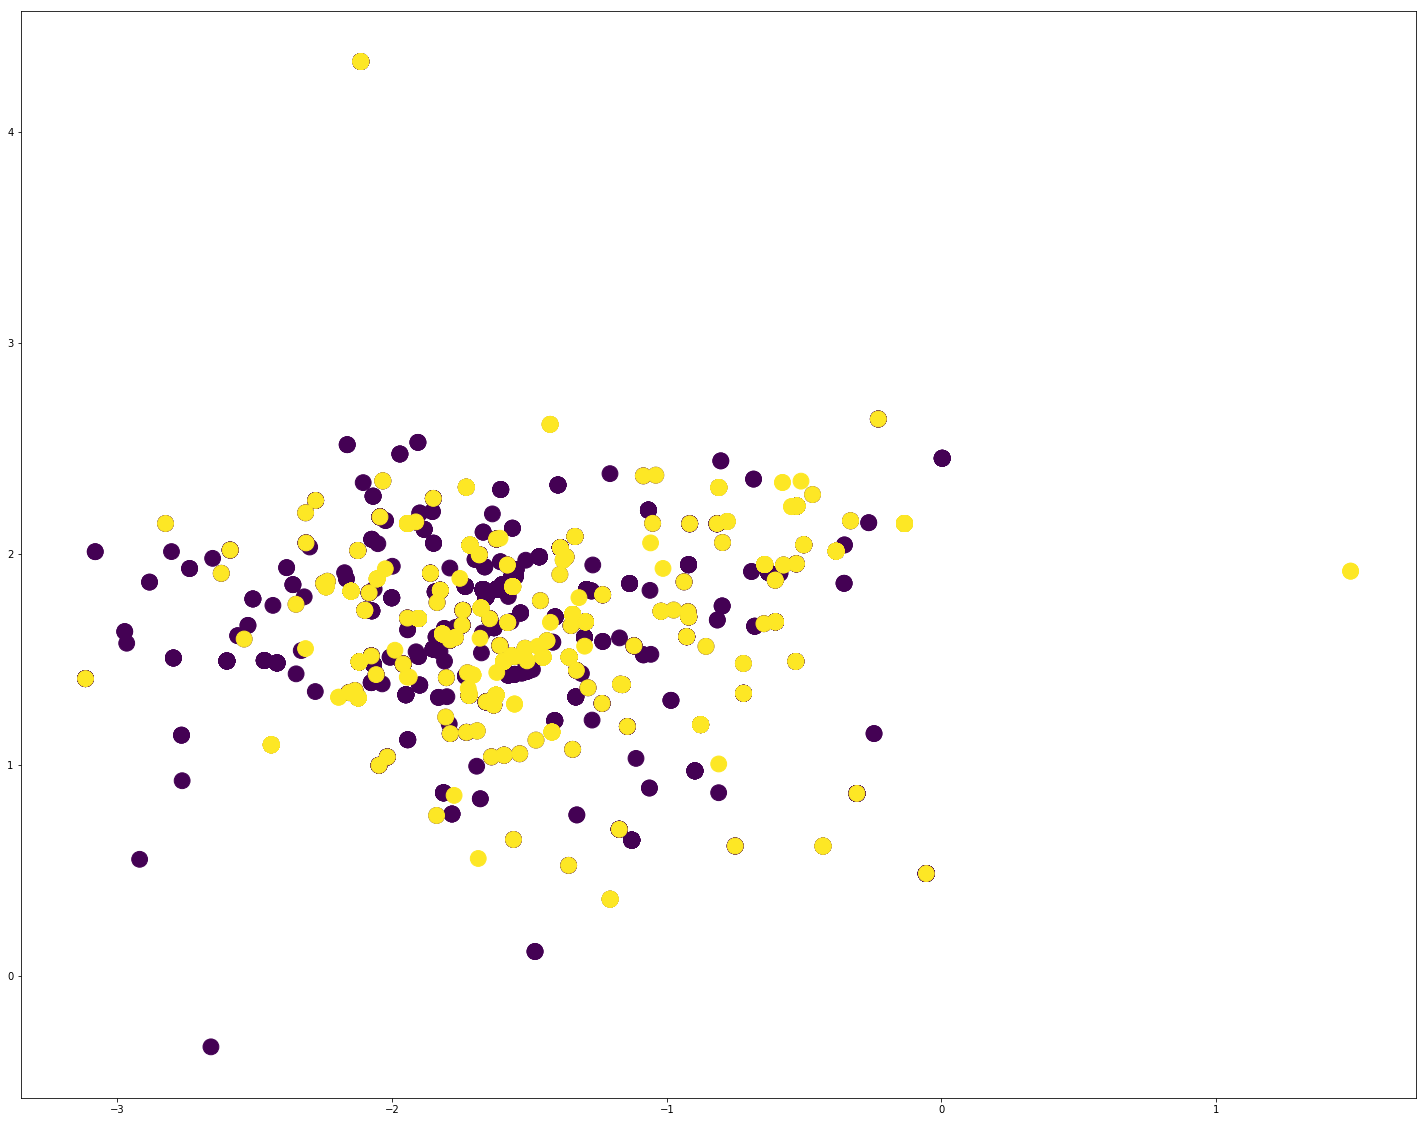

In [65]:
plt.figure(figsize=(25, 20))
plt.scatter(drawing[:, 0], drawing[:, 1], c=drawing[:, 2], s=250)
plt.show()